# California "Conservation-Consumption Score" analysis

By Ryan Menezes, Matt Stevens and Ben Welsh

[A Los Angeles Times analysis published on Oct. 31, 2016](http://www.latimes.com/local/lanow/la-me-ln-water-conservation-backslide-20161018-snap-htmlstory.html), found that the overwhelming majority of California water districts increased their usage after the state eased its drought restrictions. Some of the most extreme increases were found in inland Northern California, led by the San Juan Water District near Folsom Lake.

How did The Times come to that conclusion? Using the computer code that follows.

**Here's how it worked.**

We started by downloading data from California’s State Water Resources Control Board, which publishes a monthly accounting of each district’s water usage on its website.

That data has been used by state regulators to monitor and enforce mandatory water-use reductions introduced as part of the state’s emergency drought response. Regulators ended mandatory conservation for the vast majority of urban water suppliers this spring.

The state measures each district’s water savings by comparing the number of gallons it supplies to homes, businesses and institutions each month versus the same month in 2013, a baseline that precedes Gov. Jerry Brown’s proclamation of a drought State of Emergency.

The code below calculates that statistic for three months this summer after restrictions were eased, then compares it against the same months in 2015. In total, 93% of 387 districts increased water usage this year. Nineteen districts were excluded because they did not report enough data to the state.

California’s water districts vary greatly in size, from large urban areas like Los Angeles to small districts in the rural north. To compare suppliers and identify areas where residents use large amounts of water at home, state officials also track the total amount of water used by each district’s average resident each day.

This code combines that measure with each district’s change in total summer water usage to create a ranking we’re calling a Conservation-Consumption Score. By including both factors, this statistic -- sometimes known as a z-score -- better identifies areas where residents account for increases.

Some of the highest ranking districts by this score were found in Northern California and around Folsom Lake near Sacramento. The top score belonged to the San Juan Water District, the ultimate focus of our story.

##### Import and configure analysis tools.

In [1]:
from __future__ import division, barry_as_FLUFL
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option("display.max_columns", 500)

##### Import raw water usage data from the state 

In [3]:
supplier_path = os.path.join(os.getcwd(), 'uw_supplier_data100516.xlsx')

In [4]:
SUPPLIER_TABLE = pd.read_excel(supplier_path)

In [5]:
# Added by Steve, what size was SUPPLIER_TABLE?
SUPPLIER_TABLE.shape

(10936, 32)

In [6]:
# Added by Steve, get me those d-types
SUPPLIER_TABLE.dtypes

Supplier Name                                                                                                                                                                                                                                                   object
Stage Invoked                                                                                                                                                                                                                                                   object
Mandatory Restrictions                                                                                                                                                                                                                                          object
Reporting Month                                                                                                                                                                                                    

In [7]:
# Added by Steve
SUPPLIER_TABLE.head()

,Supplier Name,Stage Invoked,Mandatory Restrictions,Reporting Month,REPORTED Total Monthly Potable Water Production Reporting Month,REPORTED Total Monthly Potable Water Production 2013,REPORTED Monthly CII 2014/2015 (Subset of REPORTED Total Monthly Potable Water Production Reporting Month),REPORTED Monthly Ag Use Reporting Month (This value is removed from REPORTED Total Monthly Potable Water Production Reporting Month by Water Board staff to obtain CALCULATED Total Monthly Potable Water Production Reporting Month Gallons),REPORTED Monthly Ag Use 2013 (This value is removed from REPORTED Total Monthly Potable Water Production 2013 by Water Board Staff to obtain CALCULATED Total Monthly Potable Water Production 2013 Gallons),Optional - REPORTED Recycled Water,REPORTED Units,Qualification,Total Population Served,REPORTED Residential Gallons-per-Capita-Day (R-GPCD) (starting in September 2014),Optional - Enforcement Actions,Optional - Implementation,Conservation Standard (starting in June 2015)\n*Adjusted in March 2016\n**Revised in June 2016,Supplier has Agricultural Water Use Exclusion Certification (list of received certifications available at: http://www.waterboards.ca.gov/water_issues/programs/conservation_portal/agriculture/),CALCULATED Total Monthly Potable Water Production Reporting Month Gallons (Values calculated by Water Board staff. REPORTED Total Monthly Potable Water Production Reporting Month - REPORTED Monthly Ag Use Reporting Month; converted to gallons.),CALCULATED Total Monthly Potable Water Production 2013 Gallons (Values calculated by Water Board staff. REPORTED Total Monthly Potable Water Production 2013 - REPORTED Monthly Ag Use 2013; converted to gallons.),CALCULATED Monthly CII Reporting Month (Subset of CALCULATED Total Monthly Potable Water Production Reporting Month Gallons),CALCULATED R-GPCD Reporting Month (Values calculated by Water Board staff using methodology available at http://www.waterboards.ca.gov/waterrights/water_issues/programs/drought/docs/ws_tools/guidance_estimate_res_gpcd.pdf),% Residential Use,Comments/Corrections,Hydrologic Region,Water Days Allowed/Week,Complaints Received,Follow-up Actions,Warnings Issued,Rate Penalties Assessed (starting\nDec-15),Penalties Assessed,Enforcement Comments
0,East Bay Municipal Utilities District,0,No,2016-08-15,6007.50,7172.30,1141,NaN,NaN,NaN,MG,1. To provide context as EBMUD continues to fa...,1400000,84.00,Although EBMUD is not currently implementing i...,• EBMUD’s Board adopted a preliminary water sh...,0.00,No,6007500000.00,7172300000.00,1141000000,84.44,61.00,No correction,San Francisco Bay,7.00,176,69,2,0,0,Although EBMUD is not currently implementing i...
1,East Bay Municipal Utilities District,0,No,2016-07-15,6056.60,7452.20,994,NaN,NaN,NaN,MG,1. To provide context as EBMUD continues to fa...,1400000,83.00,Although EBMUD is not currently implementing i...,• EBMUD’s Board adopted a preliminary water sh...,0.00,No,6056600000.00,7452200000.00,994000000,83.73,60.00,No correction,San Francisco Bay,nan,197,47,2,0,0,Although EBMUD is not currently implementing i...
2,East Bay Municipal Utilities District,0,Yes,2016-06-15,5675.90,6927.50,839,NaN,NaN,NaN,MG,1. To provide context as EBMUD continues to fa...,1400000,82.00,"Status Update On May 10, 2016, EBMUD’s Board t...",• EBMUD’s Board adopted a preliminary water sh...,0.00,No,5675900000.00,6927500000.00,839000000,82.44,61.00,No correction,San Francisco Bay,2.00,188,82,7,0,0,"Status Update On May 10, 2016, EBMUD’s Board t..."
3,East Bay Municipal Utilities District,4,Yes,2016-05-15,4959.30,6716.50,955,NaN,NaN,NaN,MG,1. To provide context as EBMUD continues to fa...,1400000,68.00,"Status Update On May 10, 2016, EBMUD’s Board t...",• EBMUD’s Board adopted a preliminary water sh...,0.16,No,4959300000.00,6716500000.00,955000000,68.56,60.00,No correction,San Francisco Bay,2.00,166,88,5,0,30,"Status Update On May 10, 2016, EBMUD’s Board t..."
4,East Bay Municipal Utilities District,4,Yes,2016-04-15,4018.8

##### Keep the columns we want

In [8]:
supplier_table = SUPPLIER_TABLE.iloc[:,[0,3,18,19,21]]

In [9]:
supplier_table.columns = [
    'supplier_name',
    'month',
    'total_water_production_gallons',
    'total_water_production_gallons_2013',
    'residential_water_usage'
]

##### Clean them up

In [10]:
# Added by Steve to determine original type of month
supplier_table.dtypes

supplier_name                                  object
month                                  datetime64[ns]
total_water_production_gallons                float64
total_water_production_gallons_2013           float64
residential_water_usage                       float64
dtype: object

In [11]:
# Added by Steve to determine the range of observations in this data
supplier_table.month.sort_values()[[0, len(supplier_table) - 1]]

0       2016-08-15
10935   2014-07-15
Name: month, dtype: datetime64[ns]

In [12]:
supplier_table['month'] = supplier_table['month'].astype(str)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
supplier_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10936 entries, 0 to 10935
Data columns (total 5 columns):
supplier_name                          10936 non-null object
month                                  10936 non-null object
total_water_production_gallons         10936 non-null float64
total_water_production_gallons_2013    10936 non-null float64
residential_water_usage                10936 non-null float64
dtypes: float64(3), object(2)
memory usage: 427.3+ KB


In [14]:
supplier_table.head()

,supplier_name,month,total_water_production_gallons,total_water_production_gallons_2013,residential_water_usage
0,East Bay Municipal Utilities District,2016-08-15,6007500000.00,7172300000.00,84.44
1,East Bay Municipal Utilities District,2016-07-15,6056600000.00,7452200000.00,83.73
2,East Bay Municipal Utilities District,2016-06-15,5675900000.00,6927500000.00,82.44
3,East Bay Municipal Utilities District,2016-05-15,4959300000.00,6716500000.00,68.56
4,East Bay Municipal Utilities District,2016-04-15,4018800000.00,5417500000.00,59.33


##### Filter the data to only the three summer months in 2015 and 2016 

In [15]:
target_months = ['2016-08-15', '2016-07-15', '2016-06-15', '2015-08-15', '2015-07-15', '2015-06-15',]
month_table = supplier_table[supplier_table['month'].isin(target_months)]

In [16]:
# Added by Steve to determine how many duplicates existed
# There are two duplicates in this dataframe
month_table[month_table.duplicated(keep=False)]

,supplier_name,month,total_water_production_gallons,total_water_production_gallons_2013,residential_water_usage
4980,McKinleyville Community Service District,2016-08-15,46442000.00,55908000.00,64.71
4981,McKinleyville Community Service District,2016-08-15,46442000.00,55908000.00,64.71
10372,Manteca City of,2016-08-15,469336000.00,575200000.00,149.66
10373,Manteca City of,2016-08-15,469336000.00,575200000.00,149.66


In [17]:
month_table.drop_duplicates(inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
"Total records: {}".format(len(supplier_table))

'Total records: 10936'

In [19]:
"Month records: {}".format(len(month_table))

'Month records: 2425'

##### Eliminate any suppliers who have fewer or greater than six months of data with those labels 

In [20]:
supplier_counts = month_table.groupby("supplier_name")['supplier_name'].count().to_frame("count").reset_index()

In [21]:
supplier_counts[supplier_counts['count'] <> 6]

,supplier_name,count
7,"Anderson, City of",5
34,Calexico City of,5
118,Escondido City of,5
167,Hi-Desert Water District,5
195,Lemoore City of,4
200,Livingston City of,5
210,Lynwood City of,5
225,Mission Springs Water District,5
227,Monrovia City of,4
280,Porterville City of,4


In [22]:
incomplete_month_table = supplier_counts[supplier_counts['count'] <> 6]

In [23]:
incomplete_month_table

,supplier_name,count
7,"Anderson, City of",5
34,Calexico City of,5
118,Escondido City of,5
167,Hi-Desert Water District,5
195,Lemoore City of,4
200,Livingston City of,5
210,Lynwood City of,5
225,Mission Springs Water District,5
227,Monrovia City of,4
280,Porterville City of,4


In [24]:
complete_month_table = month_table[~month_table['supplier_name'].isin(incomplete_month_table['supplier_name'])]

In [25]:
"Complete month records: {}".format(len(complete_month_table))

'Complete month records: 2334'

##### Group and sum the total water production for each summer 

In [26]:
# Added by Steve, what does this completed table look like?
complete_month_table.head()

,supplier_name,month,total_water_production_gallons,total_water_production_gallons_2013,residential_water_usage
0,East Bay Municipal Utilities District,2016-08-15,6007500000.00,7172300000.00,84.44
1,East Bay Municipal Utilities District,2016-07-15,6056600000.00,7452200000.00,83.73
2,East Bay Municipal Utilities District,2016-06-15,5675900000.00,6927500000.00,82.44
12,East Bay Municipal Utilities District,2015-08-15,5250500000.00,7172300000.00,74.33
13,East Bay Municipal Utilities District,2015-07-15,5148500000.00,7452200000.00,71.69


In [27]:
summer_16_table = complete_month_table[complete_month_table['month'].isin(['2016-08-15', '2016-07-15', '2016-06-15',])]

In [28]:
summer_16_totals = summer_16_table.groupby("supplier_name")['total_water_production_gallons'].sum().to_frame("total_water_production_16").reset_index()

In [29]:
summer_16_totals.head(5)

,supplier_name,total_water_production_16
0,Adelanto City of,434024228.54
1,Alameda County Water District,3937000000.00
2,Alco Water Service,344299000.00
3,Alhambra City of,775637185.75
4,Amador Water Agency,350910000.00


In [30]:
"Summer 16 records: {}".format(len(summer_16_totals))

'Summer 16 records: 389'

In [31]:
summer_15_table = complete_month_table[complete_month_table['month'].isin(['2015-08-15', '2015-07-15', '2015-06-15',])]

In [50]:
summer_15_totals = summer_15_table.groupby("supplier_name")['total_water_production_gallons'].sum().to_frame("total_water_production_15").reset_index()

In [51]:
summer_15_totals.head(5)

,supplier_name,total_water_production_15
0,Adelanto City of,387316100.00
1,Alameda County Water District,3374000000.00
2,Alco Water Service,350899000.00
3,Alhambra City of,777996350.08
4,Amador Water Agency,287480000.00


In [52]:
"Summer 15 records: {}".format(len(summer_15_totals))

'Summer 15 records: 389'

In [53]:
summer_13_totals = summer_16_table.groupby("supplier_name")['total_water_production_gallons_2013'].sum().to_frame("total_water_production_13").reset_index()

In [54]:
summer_13_totals.head()

,supplier_name,total_water_production_13
0,Adelanto City of,393342171.40
1,Alameda County Water District,5273000000.00
2,Alco Water Service,447983000.00
3,Alhambra City of,1060724599.23
4,Amador Water Agency,431220000.00


In [55]:
# Added by Steve, 
# So we're using the 2013 totals from the 2016 report but there are 2013 values with 2015 values, too. 
# Are the 2015 and 2016 values for 2013 total water production the same?
# Yep, they're good.

# Subset data frame
kas_16 = summer_16_table[['supplier_name', 'month', 'total_water_production_gallons_2013']]
kas_15 = summer_15_table[['supplier_name', 'month', 'total_water_production_gallons_2013']]

# Transform month
kas_15.loc[:,'month'] = kas_15.month.apply(lambda x: x[5:7])
kas_16.loc[:,'month'] = kas_16.month.apply(lambda x: x[5:7])

# Give unique names before merge
kas_15.rename(columns={'total_water_production_gallons_2013': 'values_2015'}, inplace=True)
kas_16.rename(columns={'total_water_production_gallons_2013': 'values_2016'}, inplace=True)

# Merge tables
kas_13 = kas_16.merge(kas_15, on=['supplier_name', 'month'])
kas_13['delta'] = kas_13.values_2015 - kas_13.values_2015
kas_13[(kas_13.delta <> 0)]

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,supplier_name,month,values_2016,values_2015,delta


In [56]:
"Summer 13 records: {}".format(len(summer_13_totals))

'Summer 13 records: 389'

##### Join those summer production totals into a combined table

In [57]:
# Added by Steve, is this really an inner join or effectively an outer join?
# Both sets are empty, thus it's an outer join
#
print(set(summer_15_totals.supplier_name.unique()).difference(set(summer_16_totals.supplier_name.unique())))
print(set(summer_16_totals.supplier_name.unique()).difference(set(summer_15_totals.supplier_name.unique())))

set()
set()


In [58]:
summer_table = summer_16_totals.merge(summer_15_totals, on="supplier_name")
summer_table = summer_table.merge(summer_13_totals, on="supplier_name")

In [59]:
"Total summer records: {}".format(len(summer_table))

'Total summer records: 389'

In [60]:
summer_table.head(5)

,supplier_name,total_water_production_16,total_water_production_15,total_water_production_13
0,Adelanto City of,434024228.54,387316100.00,393342171.40
1,Alameda County Water District,3937000000.00,3374000000.00,5273000000.00
2,Alco Water Service,344299000.00,350899000.00,447983000.00
3,Alhambra City of,775637185.75,777996350.08,1060724599.23
4,Amador Water Agency,350910000.00,287480000.00,431220000.00


In [61]:
# Added by Steve, Could we make summer_Table with only one table?

# Flush out real date fields
sk_tab = complete_month_table.copy()
sk_tab['date'] = pd.to_datetime(sk_tab['month'])
sk_tab['month'] = sk_tab['date'].apply(lambda x: x.month)
sk_tab['year'] = sk_tab['date'].apply(lambda x: x.year)

sk_tab.drop(['residential_water_usage', 'date'], axis=1, inplace=True)

# Turn that column for 2013 into table records
sk_tab = sk_tab.melt(id_vars=['supplier_name', 'year', 'month'])
sk_tab.drop_duplicates(['month', 'variable', 'value'], inplace=True)
sk_tab.loc[sk_tab.variable == 'total_water_production_gallons_2013', 'year'] = 2013
sk_tab.drop(['variable', 'month'], inplace=True, axis=1)
sk_tab.rename(index=str, columns={'value': 'gallons'}, inplace=True)

sk_tab.year = sk_tab.year.apply(lambda x: 'total_water_production_' + str(x - 2000))
sk_tab = sk_tab.groupby(['supplier_name', 'year'])['gallons'].sum().to_frame('gallons').unstack().reset_index(col_level=1)
sk_tab['gallons', 'total_water_production_13'] = sk_tab['gallons','total_water_production_13'] / 2

sk_tab.head()

gallons  \
year                  supplier_name total_water_production_13   
0                  Adelanto City of              420745085.70   
1     Alameda County Water District             3475000000.00   
2                Alco Water Service              223991500.00   
3                 Alhambra  City of              892539643.70   
4               Amador Water Agency              368850000.00   

                                                          
year total_water_production_15 total_water_production_16  
0                 387316100.00              434024228.54  
1                3374000000.00             3937000000.00  
2                 350899000.00              344299000.00  
3                 777996350.08              775637185.75  
4                 287480000.00              350910000.00

In [62]:
# Added by Steve
"Total summer records: {}".format(len(sk_tab))

'Total summer records: 389'


##### Calculate the percentage change of summers 15 and 16 versus the baseline of summer 2013

In [63]:
summer_table['savings_16'] = summer_table.apply(
    lambda x: (x['total_water_production_16']-x['total_water_production_13'])/float(x['total_water_production_13']),
    axis=1
)

In [64]:
summer_table['savings_15'] = summer_table.apply(
    lambda x: (x['total_water_production_15']-x['total_water_production_13'])/float(x['total_water_production_13']),
    axis=1
)

In [65]:
summer_table.sort_values('savings_16', ascending=False).head()

,supplier_name,total_water_production_16,total_water_production_15,total_water_production_13,savings_16,savings_15
0,Adelanto City of,434024228.54,387316100.00,393342171.40,0.10,-0.02
236,North Marin Water District,1134200000.00,715000000.00,1102000000.00,0.03,-0.35
166,Humboldt Bay Municipal Water District,50810000.00,53060000.00,49765000.00,0.02,0.07
10,Arcata City of,180277000.00,177507000.00,178787000.00,0.01,-0.01
124,Fortuna City of,125000000.00,119100000.00,127100000.00,-0.02,-0.06


##### Calculate the difference between in that statistic between 15 and 16

In [66]:
summer_table['savings_change'] = summer_table.apply(
    lambda x: x['savings_16']-x['savings_15'],
    axis=1
)

In [67]:
summer_table.head(5)

,supplier_name,total_water_production_16,total_water_production_15,total_water_production_13,savings_16,savings_15,savings_change
0,Adelanto City of,434024228.54,387316100.00,393342171.40,0.10,-0.02,0.12
1,Alameda County Water District,3937000000.00,3374000000.00,5273000000.00,-0.25,-0.36,0.11
2,Alco Water Service,344299000.00,350899000.00,447983000.00,-0.23,-0.22,-0.01
3,Alhambra City of,775637185.75,777996350.08,1060724599.23,-0.27,-0.27,-0.00
4,Amador Water Agency,350910000.00,287480000.00,431220000.00,-0.19,-0.33,0.15


##### Rank the cities that have regressed the most towards their 2013 baseline

In [68]:
summer_table.sort_values("savings_change", ascending=False).head()

,supplier_name,total_water_production_16,total_water_production_15,total_water_production_13,savings_16,savings_15,savings_change
236,North Marin Water District,1134200000.00,715000000.00,1102000000.00,0.03,-0.35,0.38
313,San Juan Water District,1783309914.14,1204845426.88,2045265134.82,-0.13,-0.41,0.28
314,San Lorenzo Valley Water District,206498200.00,138808800.00,243345319.00,-0.15,-0.43,0.28
123,Folsom City of,2425963874.01,1835195236.86,2725421335.43,-0.11,-0.33,0.22
321,Santa Fe Irrigation District,1035523249.86,763209212.32,1257134805.37,-0.18,-0.39,0.22


##### Calculate the average monthly water usage per person (R-GPCD) in each district for the summer of 2016

In [69]:
summer_16_means = summer_16_table.groupby('supplier_name')['residential_water_usage'].mean().to_frame("residential_water_usage_mean_16").reset_index()

In [70]:
summer_16_means.head(5)

,supplier_name,residential_water_usage_mean_16
0,Adelanto City of,117.48
1,Alameda County Water District,84.23
2,Alco Water Service,103.25
3,Alhambra City of,89.18
4,Amador Water Agency,102.61


##### Join those water usage average to our combined table

In [71]:
# Added by Steve, is this really an inner join or effectively an outer join?
# Both sets are empty, thus it's an outer join
#
print(set(summer_16_means.supplier_name.unique()).difference(set(summer_table.supplier_name.unique())))
print(set(summer_table.supplier_name.unique()).difference(set(summer_16_means.supplier_name.unique())))

set()
set()


In [72]:
summer_table = summer_table.merge(summer_16_means, on="supplier_name")

In [80]:
summer_table.head(50)

,supplier_name,total_water_production_16,total_water_production_15,total_water_production_13,savings_16,savings_15,savings_change,residential_water_usage_mean_16
0,Adelanto City of,434024228.54,387316100.00,393342171.40,0.10,-0.02,0.12,117.48
1,Alameda County Water District,3937000000.00,3374000000.00,5273000000.00,-0.25,-0.36,0.11,84.23
2,Alco Water Service,344299000.00,350899000.00,447983000.00,-0.23,-0.22,-0.01,103.25
3,Alhambra City of,775637185.75,777996350.08,1060724599.23,-0.27,-0.27,-0.00,89.18
4,Amador Water Agency,350910000.00,287480000.00,431220000.00,-0.19,-0.33,0.15,102.61
5,"American Canyon, City of",279580524.37,282187335.78,387763198.13,-0.28,-0.27,-0.01,76.21
6,Anaheim City of,5449865116.58,4767206377.01,6479881477.32,-0.16,-0.26,0.11,92.56
7,Antioch City of,1574516000.00,1343744000.00,2102293000.00,-0.25,-0.36,0.11,99.83
8,Apple Valley Ranchos Water Company,1038062711.62,978193122.01,1446543958.34,-0.28,-0.32,0.04,122.40
9,Arcadia City of,1328496267.88,1248239061.41,1755687488.68,-0.24,-0.29,0.05,177.55


##### Calculate summary statistics to judge how many districts regressed in summer 2016

In [74]:
savings_16 = (summer_table.total_water_production_16.sum() - summer_table.total_water_production_13.sum()) / (summer_table.total_water_production_13.sum())
savings_15 = (summer_table.total_water_production_15.sum() - summer_table.total_water_production_13.sum()) / (summer_table.total_water_production_13.sum())

In [75]:
"State water use overall backslid {} percentage points".format((savings_16 - savings_15)*100)

'State water use overall backslid 8.803881517280923 percentage points'

In [76]:
pct_backslid = len(summer_table[summer_table['savings_change'] > 0]) / len(summer_table)

In [77]:
"{}% of urban districts in the state backslid".format(pct_backslid*100)

'92.80205655526991% of urban districts in the state backslid'

Text(0.5, 0, "Change in water savings between summer '15 and summer '16")

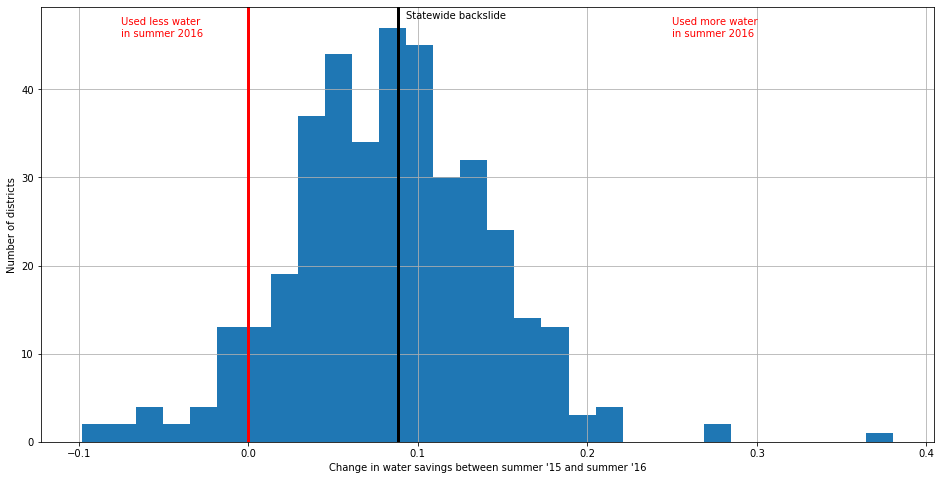

In [78]:
plt.figure(figsize=(16,8))
summer_table.savings_change.hist(bins=30)
plt.axvline(0, linewidth=3, c='red')
plt.axvline(savings_16 - savings_15, c='black', linewidth=3)
plt.annotate("Statewide backslide", (0.093, 48))
plt.annotate("Used less water\nin summer 2016", (-0.075, 46), color='red')
plt.annotate("Used more water\nin summer 2016", (0.25, 46), color='red')
plt.ylabel("Number of districts")
plt.xlabel("Change in water savings between summer '15 and summer '16")

##### Calculate a "Conservation-Consumption Score" that adjusts the savings change by the amount of water usage to surface the high-usage districts that regressed the most 

This indexed score:
1. Accounts for how much a district's savings changed between the summers of 2015 and 2016 (in the numerator)
2. Gives greater weight to districts with high residential water use (RGPCD). Positive scores indicate districts that backslid (in the denominator)

$$
CCS = \frac{SavingsChange}{\frac{1}{\sqrt{RGPCD16}}}
$$

In [79]:
summer_table['cc_score'] = (summer_table['savings_change']) / np.sqrt(1/summer_table['residentiexal_water_usage_mean_16'])

KeyError: 'residentiexal_water_usage_mean_16'

In [ ]:
summer_table.sort_values("cc_score", ascending=False).head(10)

In [ ]:
summer_table.sort_values("cc_score").head(10)

In [ ]:
plt.figure(figsize=(16,8))
summer_table.cc_score.hist(bins=30)
plt.axvline(0, linewidth=3, c='red')
plt.annotate("Used less water\nin summer 2016", (-1.5,52), color='red')
plt.annotate("Used more water\nin summer 2016", (4.05,52), color='red')
plt.ylabel("Number of districts")
plt.xlabel("Conservation-Consumption Score")

### Write the combined table out to a CSV 

In [ ]:
summer_table.sort_values("cc_score", ascending=False).to_csv("analysis.csv", index=False)